In [1]:
workspace = '/data/ChaochaoData/DSA-DL/HyperMorph/Naive/'
util_dir = '/data/ChaochaoData/DSA-DL/Utilities/'
train_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTrain'
test_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTest'
cm_train_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/train_dataset'
cm_test_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/test_dataset'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
import tensorflow as tf
import os, sys
import nibabel as nib
import cv2
# from scipy import ndimage
# from IPython import display  # Would conflict with Python's display
import IPython
import logging
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.experimental.output_all_intermediates(True)
tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

In [4]:
sys.path.insert(0, util_dir)
from utils import *

Loading BokehJS ...

# Data

In [5]:
folders_train_old = [os.path.join(train_dir, f) for f in sorted(os.listdir(train_dir))
                     if not os.path.isfile(os.path.join(train_dir, f))]
folders_test_old = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))
                    if not os.path.isfile(os.path.join(test_dir, f))]
print(len(folders_train_old), len(folders_test_old))

folders_train_cm = [os.path.join(cm_train_dir, f) for f in sorted(os.listdir(cm_train_dir))
                    if not os.path.isfile(os.path.join(cm_train_dir, f))]
folders_test_cm = [os.path.join(cm_test_dir, f) for f in sorted(os.listdir(cm_test_dir))
                   if not os.path.isfile(os.path.join(cm_test_dir, f))]
print(len(folders_train_cm), len(folders_test_cm))

folders_train = folders_train_old + folders_train_cm
folders_test = folders_test_old + folders_test_cm

ids_remove_train = [459, 4042]
# for i in sorted(ids_remove_train, reverse=True):
#     del folders_train[i]

print(len(folders_train), len(folders_test))

4946 100
100 94
5046 194


# Model

In [6]:
image_shape = (512, 512)

hp_input = tf.keras.Input(shape=[1])
x = tf.keras.layers.Dense(32, activation='relu')(hp_input)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
hypernetwork = tf.keras.Model(hp_input, x, name='hypernetwork')
# hypernetwork.summary()

model = vxm.networks.VxmDense(image_shape, int_steps=0, hyp_model=hypernetwork)
# model.summary()

In [7]:
model_path = os.path.join(workspace, 'dsa-hyper-naive.h5')

if os.path.exists(model_path):
  model.load_weights(model_path)
  print('Model has been found and loaded')

In [8]:
# def estimate_vessel_layer(dsa):
#     vessel_mask = tf.cast(tf.less(dsa, 0), dtype=tf.float32)
#     vessel_layer = dsa * vessel_mask
#     return vessel_layer

In [9]:
# def min_pool(img, ks=3):  # choose ks as an odd number
#   return -tf.nn.max_pool(-img, ksize=ks, strides=1, padding="SAME")

# def estimate_vessel_layer(img_bg, img_ct, ks=3):
#   dsa = img_ct - img_bg

#   img_bg_fil = min_pool(img_bg, ks=ks)
#   dsa_fil = img_ct - img_bg_fil
#   mask = tf.cast(tf.less_equal(dsa_fil, 0), dtype=tf.float32)
#   layer = dsa * mask

#   return layer, mask

In [10]:
# def estimate_vessel_layer_prob(img_bg, img_ct, ks=7, rate=1, prob_cutoff=0.9):
#   patch_bg = tf.image.extract_patches(img_bg,
#                                       sizes=[1, ks, ks, 1],
#                                       strides=[1, 1, 1, 1],
#                                       rates=[1, rate, rate, 1],
#                                       padding='SAME')
#   patch_diff = img_ct - patch_bg
#   patch_lt = tf.cast(tf.less(patch_diff, 0), dtype=tf.float32)
#   patch_count = tf.reduce_sum(patch_lt, axis=-1, keepdims=True)

#   matte = patch_count / ks**2  # patch_prob
#   cut_mask = tf.cast(tf.greater_equal(matte, prob_cutoff), dtype=tf.float32)
#   matte = matte * cut_mask
  
#   dsa = img_ct - img_bg
#   matte = matte * tf.cast(tf.less(dsa, 0), dtype=tf.float32)
#   layer = dsa * matte

#   return layer, matte

In [11]:
# def masked_mse(yt, yp, img_sigma=1.0):
#     '''
#     yt: fixed image (with vessels)
#     yp: predicted moved image (without vessels)
#     '''
#     dsa = yt - yp
#     # vss = estimate_vessel_layer(dsa)
#     # vss, _ = estimate_vessel_layer(yp, yt, ks=3)
#     vss, _ = estimate_vessel_layer_prob(yp, yt, ks=21, rate=5, prob_cutoff=0.1)
#     loss = vxm.losses.MSE(img_sigma).loss(yt - vss, yp)

#     return loss

In [13]:
# 'mse' in locals()

def mse(yt, yp, img_sigma=1.0):
    return vxm.losses.MSE(img_sigma).loss(yt, yp)

In [14]:
img_sigma = 0.3
lambda_weight = hp_input   # true range: [0,1]

image_loss = lambda yt, yp: mse(yt, yp, img_sigma=img_sigma) * (1 - lambda_weight)
gradient_loss = lambda yt, yp: vxm.losses.Grad('l2').loss(yt, yp) * lambda_weight
losses = [image_loss, gradient_loss]

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss=losses)

# Visual Examination

In [15]:
i_seq = np.random.randint(len(folders_train))
# i_seq = ids_remove_train[0]
print(i_seq)

293


In [16]:
xrays = load_xray_seq(folders=folders_train, i_seq=i_seq)
print(f'check xray seq range: [{xrays.min()}, {xrays.max()}]')

check xray seq range: [0.0, 1.0]


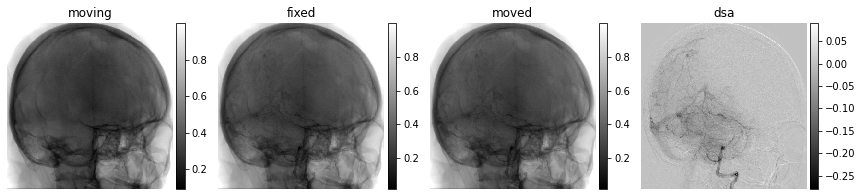

In [17]:
## Original DSA

inputs, outputs = hpm_seq_generator(folders=folders_train, i_seq=i_seq)

image_moving = inputs[0][0:1]
image_fixed = inputs[1][0:1]
image_moved = outputs[0][0:1]
dsa = image_fixed - image_moving

images = [image_moving.squeeze(), image_fixed.squeeze(), image_moved.squeeze(), dsa.squeeze()]
titles = ['moving', 'fixed', 'moved', 'dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

λ: 0.50


2023-10-31 05:52:28.451192: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 05:52:29.190627: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-10-31 05:52:29.190859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40546 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6
2023-10-31 05:52:29.271785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-10-31 05:52:32.604692: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the ma

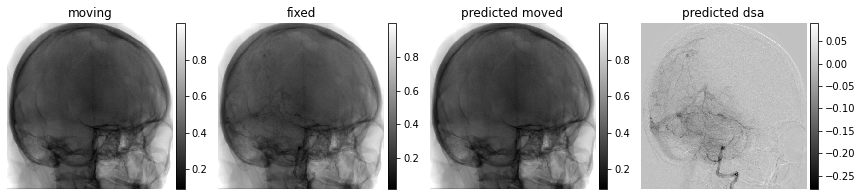

In [18]:
## Predicted DSA

# hyperparam = inputs[2][0:1]
hyperparam = np.array([[0.5]])
print(f'λ: {hyperparam[0,0]:.2f}')

pred = model.predict((image_moving, image_fixed, hyperparam), verbose=0)
image_pred = pred[0]
warp_pred = pred[1]

dsa_pred = image_fixed - image_pred

images = [image_moving.squeeze(), image_fixed.squeeze(), image_pred.squeeze(), dsa_pred.squeeze()]
titles = ['moving', 'fixed', 'predicted moved', 'predicted dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

# Training

## Single Training

In [26]:
i_seq = np.random.randint(len(folders_train))

In [27]:
# inputs, outputs = hpm_seq_generator(folders_train, i_seq, nhps=2)
inputs, outputs = hpm_seq_generator(folders_train, i_seq, nimgs=50, replace=True, nhps=1)
print(inputs[0].shape, inputs[1].shape, inputs[2].shape)
# print(inputs[2].squeeze())
print(outputs[0].shape, outputs[1].shape)

(50, 512, 512, 1) (50, 512, 512, 1) (50, 1)
(50, 512, 512, 1) (50, 512, 512, 2)


Is image_fixed same as image_moved?  True


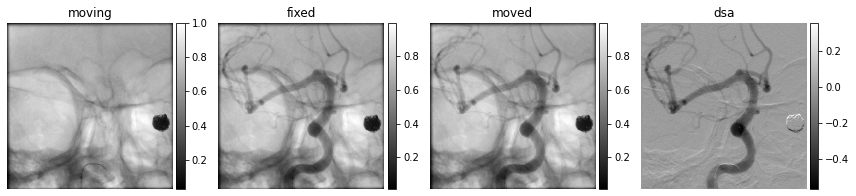

In [28]:
i_img = np.random.randint(inputs[0].shape[0])
image_moving = inputs[0][i_img]
image_fixed = inputs[1][i_img]
image_moved = outputs[0][i_img]
dsa = image_fixed - image_moving
print( 'Is image_fixed same as image_moved? ', np.array_equal(image_fixed, image_moved) )

images = [image_moving.squeeze(), image_fixed.squeeze(), image_moved.squeeze(), dsa.squeeze()]
titles = ['moving', 'fixed', 'moved', 'dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

In [29]:
history = model.fit(inputs, outputs, epochs=5, batch_size=1)

Train on 50 samples
Epoch 1/5
50/50 [==============================] - 3s 68ms/sample - loss: 0.0250 - vxm_dense_transformer_loss: 0.0249 - vxm_dense_flow_loss: 6.7009e-05
Epoch 2/5
50/50 [==============================] - 3s 66ms/sample - loss: 0.0244 - vxm_dense_transformer_loss: 0.0243 - vxm_dense_flow_loss: 1.2550e-04
Epoch 3/5
50/50 [==============================] - 3s 69ms/sample - loss: 0.0243 - vxm_dense_transformer_loss: 0.0241 - vxm_dense_flow_loss: 1.3852e-04
Epoch 4/5
50/50 [==============================] - 3s 67ms/sample - loss: 0.0244 - vxm_dense_transformer_loss: 0.0244 - vxm_dense_flow_loss: 4.6725e-05
Epoch 5/5
50/50 [==============================] - 3s 69ms/sample - loss: 0.0243 - vxm_dense_transformer_loss: 0.0242 - vxm_dense_flow_loss: 1.3099e-04


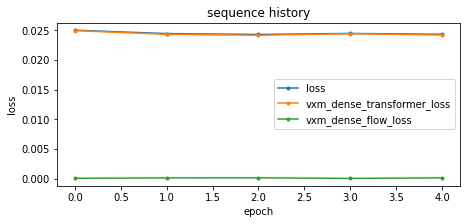

In [30]:
plot_history(history)

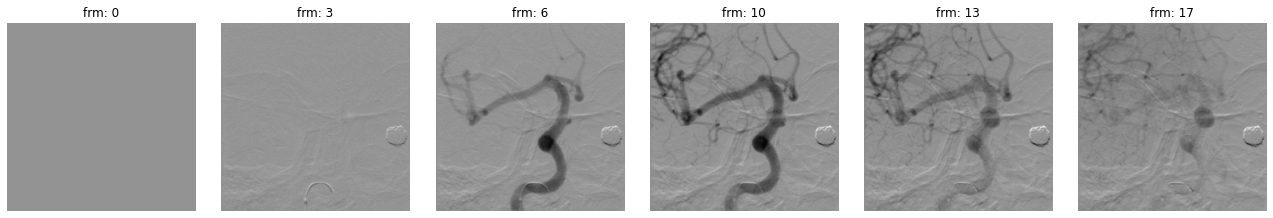

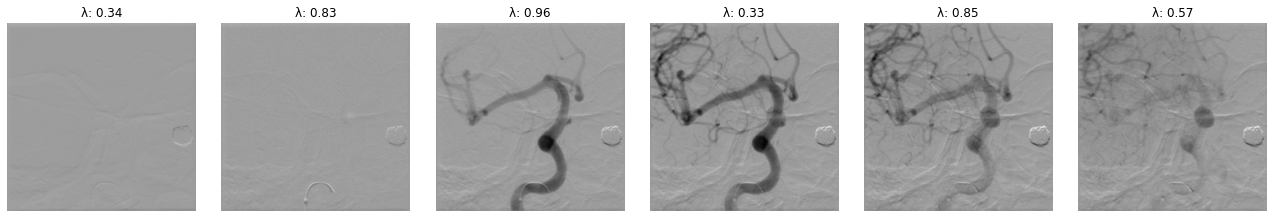

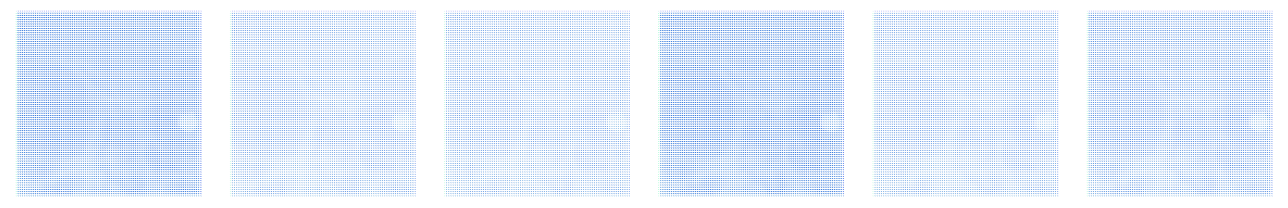

In [31]:
plot_dsa_predictions(model=model, folders=folders_train, i_seq=i_seq, nhps=1)

In [32]:
model.save_weights(model_path)

## Epoch Training

Epoch 9, Seq idx 1200, complete 5044 out of 5044


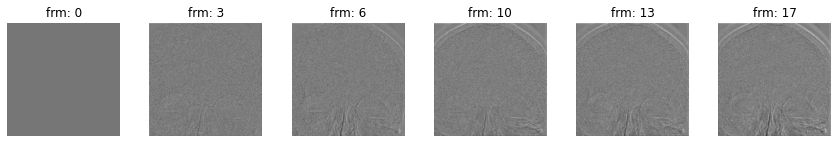

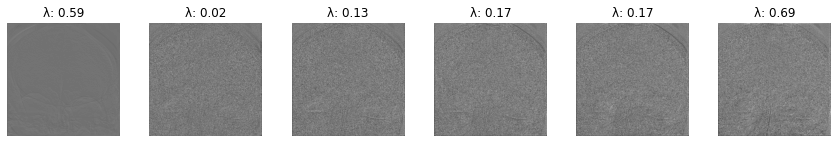

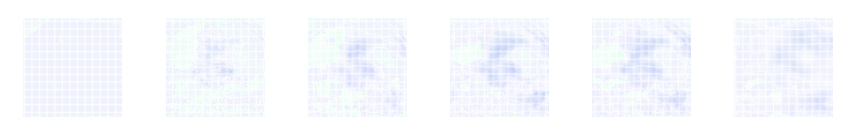

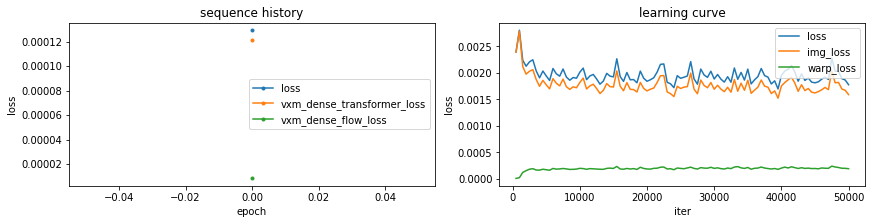

In [35]:
N_epochs = 10
N_seqs = len(folders_train)
iters_save = 500
iters_lc = 500
iters_plot = 10

global_history = {}
global_history['iter'] = []
global_history['loss'] = []
global_history['img_loss'] = []
global_history['warp_loss'] = []

iters_count = 0

l = []
l_img = []
l_warp = []

for epoch in range(N_epochs):
  indices_seq = np.random.permutation(N_seqs)
  indices_seq = [item for item in indices_seq if item not in ids_remove_train]
  for i, i_seq in enumerate(indices_seq):
    iters_count += 1

    # inputs, outputs = hpm_seq_generator(folders_train, i_seq=i_seq, nimgs=None, nhps=2)
    inputs, outputs = hpm_seq_generator(folders_train, i_seq, nimgs=50, replace=True, nhps=1)
    seq_history = model.fit(inputs, outputs, epochs=1, batch_size=1, verbose=0)

    l.append(seq_history.history['loss'][-1])
    l_img.append(seq_history.history['vxm_dense_transformer_loss'][-1])
    l_warp.append(seq_history.history['vxm_dense_flow_loss'][-1])

    if iters_count % iters_save == 0:
      model.save_weights(model_path)

    if iters_count % iters_lc == 0:
      global_history['iter'].append(iters_count)
      global_history['loss'].append(np.mean(l))
      global_history['img_loss'].append(np.mean(l_img))
      global_history['warp_loss'].append(np.mean(l_warp))
      l = []
      l_img = []
      l_warp = []

    if iters_count % iters_plot == 0:
      IPython.display.clear_output(wait=True)
      print(f'Epoch {epoch}, Seq idx {i_seq}, complete {i+1} out of {len(indices_seq)}')
      plot_dsa_predictions(model=model, folders=folders_train, i_seq=i_seq, nhps=1, sub_width=2)
      plot_history(seq_history, global_history, figsize=(12, 3))

model.save_weights(model_path)

In [ ]:
# N_seqs = len(folders_train)
# indices_seq = np.random.permutation(N_seqs)
# indices_seq = [item for item in indices_seq if item not in ids_remove_train]
# len(indices_seq)

# Interactive Search

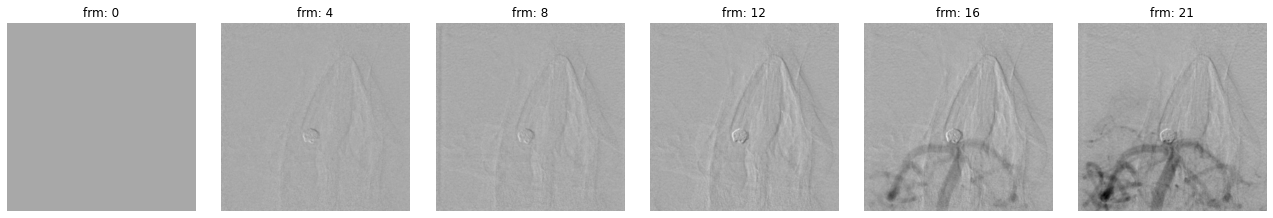

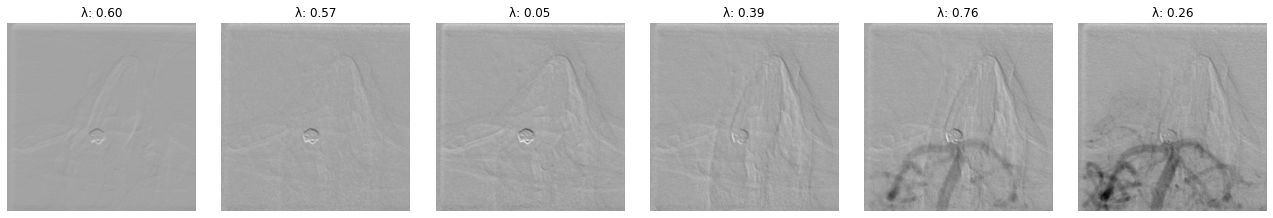

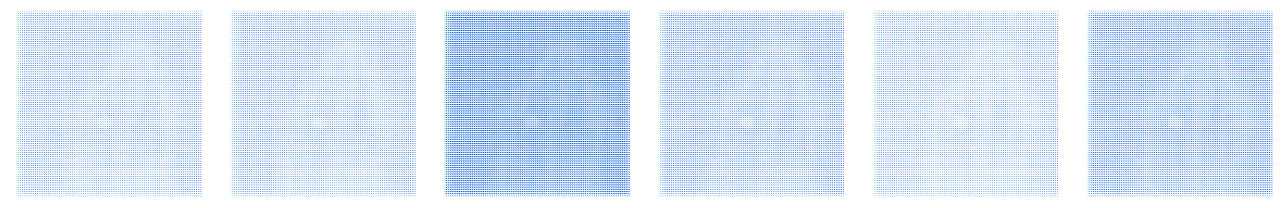

In [33]:
i_seq = np.random.randint(len(folders_train))
plot_dsa_predictions(model=model, folders=folders_train, i_seq=i_seq, nhps=1)

In [34]:
test_data = load_xray_seq(folders=folders_train, i_seq=i_seq)
run_interactive_search_1p(model, test_data, hp0=0.5)

Output()